<a href="https://colab.research.google.com/github/Tel13/PyTorch/blob/main/ConvolutionalNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
# Import data for CNN (minist)
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [38]:
# Convert MNIST image files in into tensor of 4 dimensions (nr of images, height, width, color intensiti)
transform = transforms.ToTensor()


In [39]:
# Train our data
train_data = datasets.MNIST(root='/cnn_data', train=True, download=True, transform=transform)

In [40]:
# Test data
test_data = datasets.MNIST(root='/cnn_data', train=False, download=True, transform=transform)

In [41]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: /cnn_data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [42]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: /cnn_data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [43]:
# create a small batch size for images, 10
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [44]:
# Define our CNN model
# Describe convolutional layer and what it is doing (2 convolutional layer)
conv1 = nn.Conv2d(1, 6, 3, 1)
conv2 = nn.Conv2d(6, 16, 3, 1)

In [45]:
# grab 1 MNIST record
for i, (X_Train, y_train) in enumerate(train_data):
  break

In [46]:
X_Train.shape

torch.Size([1, 28, 28])

In [47]:
x = X_Train.view(1,1,28,28)

In [48]:
# perform our first convolution
x = F.relu(conv1(x)) # rectified linear unit for our activation function

In [49]:
# 1 single image, 6 = filters, 26x26 the size of image
x.shape

torch.Size([1, 6, 26, 26])

In [50]:
# pass thru the poolig layer
x = F.max_pool2d(x,2,2) # kernel of 2 and stride of 2

In [51]:
x.shape

torch.Size([1, 6, 13, 13])

In [52]:
# Do our second convolutionallayer
x = F.relu(conv2(x))

In [53]:
x.shape # we didn't set padding so we loose 2 pixles

torch.Size([1, 16, 11, 11])

In [54]:
# pooling layer
x =F.max_pool2d(x, 2, 2)

In [55]:
x.shape # 11/2 = 5.5 we have to round down because we loose data

torch.Size([1, 16, 5, 5])

In [77]:
# Model class
class ConvolutionalNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1,6,3,1)
    self.conv2 = nn.Conv2d(6,16,3,1)
    # Fully connected layer
    self.fc1 = nn.Linear(5*5*16, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, X):
    X = F.relu(self.conv1(X))
    X = F.max_pool2d(X,2,2) # 2x2 kernel and stride 2
    #Second pass
    X = F.relu(self.conv2(X))
    X = F.max_pool2d(X,2,2)

    # Re-view to flatten it out
    X = X.view(-1, 16*5*5) # negative one so that we can vary the batch size

    # Fully connected layers
    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X)
    return F.log_softmax(X, dim=1)

In [78]:
# Create an instance of our model
torch.manual_seed(41)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [79]:
# Loss function optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # smaller the lernig rate the longher its gonna to train


In [80]:
# model train
import time
start_time = time.time()

# Create variables to tracks things
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

# Create a for loop of Epochs
for i in range(epochs):
  trn_corr = 0
  tst_corr = 0

  # Train
  for b,(X_train, y_train) in enumerate(train_loader):
    b += 1 # start our batches at 1
    y_pred = model(X_train) # get predicted vlues from the traning set: is 2d
    loss = criterion(y_pred, y_train) # how off are we?

    predicted = torch.max(y_pred.data, 1)[1] # add up the number of correct predictions. Indexed off the first point
    batch_corr = (predicted == y_train).sum() # hoe manywe got correct from this batch.
    trn_corr += batch_corr # keep track as we go along in training

    #Update our parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #Print our parameters
    if b%600 == 0:
      print(f'Epoch: {i} Batch: {b} Loss: {loss.item()}')

  train_losses.append(loss)
  train_correct.append(trn_corr)

  # Test
  with torch.no_grad(): # no gradient so we do not update our wights and bases with test
    for b,(X_test, y_test) in enumerate(test_loader):
      y_val = model(X_test)
      predicted = torch.max(y_val.data, 1)[1] # Adding up correct predictions
      tst_corr += (predicted == y_test).sum()

  loss = criterion(y_val, y_test)
  test_losses.append(loss)
  test_correct.append(tst_corr)


current_time = time.time()
total = current_time-start_time
print(f'Training took: {total/60} minutes!')

Epoch: 0 Batch: 600 Loss: 0.1623610556125641
Epoch: 0 Batch: 1200 Loss: 0.1502392590045929
Epoch: 0 Batch: 1800 Loss: 0.4744560718536377
Epoch: 0 Batch: 2400 Loss: 0.14238706231117249
Epoch: 0 Batch: 3000 Loss: 0.007758188061416149
Epoch: 0 Batch: 3600 Loss: 0.3836284875869751
Epoch: 0 Batch: 4200 Loss: 0.0038223876617848873
Epoch: 0 Batch: 4800 Loss: 0.0021286322735249996
Epoch: 0 Batch: 5400 Loss: 0.0569545142352581
Epoch: 0 Batch: 6000 Loss: 0.00038789428072050214
Epoch: 1 Batch: 600 Loss: 0.005851339548826218
Epoch: 1 Batch: 1200 Loss: 0.3855525553226471
Epoch: 1 Batch: 1800 Loss: 0.004819948226213455
Epoch: 1 Batch: 2400 Loss: 0.003216963727027178
Epoch: 1 Batch: 3000 Loss: 0.0332382395863533
Epoch: 1 Batch: 3600 Loss: 0.5372857451438904
Epoch: 1 Batch: 4200 Loss: 0.04561494290828705
Epoch: 1 Batch: 4800 Loss: 0.0007510822033509612
Epoch: 1 Batch: 5400 Loss: 0.0001173773780465126
Epoch: 1 Batch: 6000 Loss: 0.14201366901397705
Epoch: 2 Batch: 600 Loss: 0.023733172565698624
Epoch: 2

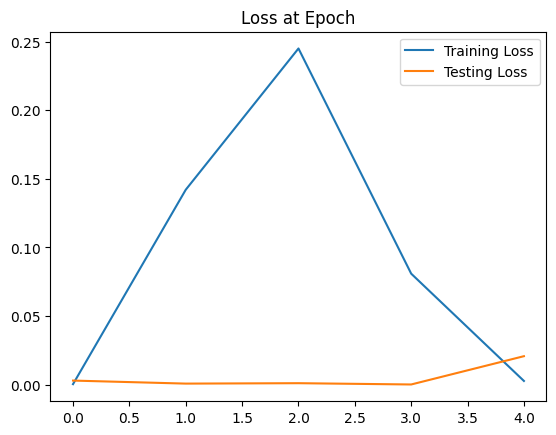

In [85]:
# graph the loss at epoch
train_losses = [tl.item() for tl in train_losses]
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Testing Loss')
plt.title('Loss at Epoch')
plt.legend()

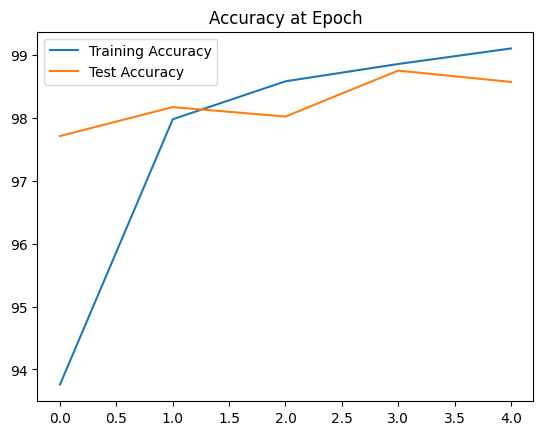

In [92]:
# graph the accuracy at the end of each epoch
train_accuracy = [t/600 for t in train_correct]
plt.plot(train_accuracy, label='Training Accuracy')
test_accuracy = [t/100 for t in test_correct]
plt.plot(test_accuracy, label='Test Accuracy')
plt.title('Accuracy at Epoch')
plt.legend()

In [93]:
test_load_everything = DataLoader(test_data, batch_size=10000, shuffle=False)

In [94]:
with torch.no_grad():
  correct = 0
  for X_test,y_test in test_load_everything:
    y_val = model(X_test)
    predicted = torch.max(y_val.data, 1)[1]
    correct += (predicted == y_test).sum()
  print(f'Test Accuracy: {correct/10000}')

Test Accuracy: 0.9857000112533569


In [95]:
# Did for correct
correct.item()

9857